In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [2]:
h = 0.2

dist = 0.5
sphere1 = bempp.api.shapes.sphere(h=h, origin=((dist/2) + 1, 0, 0))
sphere2 = bempp.api.shapes.sphere(h=h, origin=(-((dist/2) + 1), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

wavenumber = 0.8j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

combined = np.linalg.inv(mat2).dot(mat)
sign, logdet = slogdet(combined)
print(logdet)

-0.11725914620404754


In [3]:
evals, evects = np.linalg.eig(combined)

In [4]:
import krypy

In [152]:
num_ = 10
dim = 100

In [153]:
result_1 = []
for index_ in range(num_):
    x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))
    
    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(index_, index_ + 50):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[index_]
        v_index = list(evalue).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_1.append(rho_)
    
result_2 = []
for index_ in range(1, num_+1):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(index_, index_ + 50):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[-index_]
        v_index = list(evalue).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_2.append(rho_)   
    
result_ = result_1 + result_2 

logdet_approx = 0
for i in range(len(result_)):
    logdet_approx += np.log(result_[i])

err = (logdet_approx - logdet)/logdet
print(abs(err))

0.0016222857498242053


In [13]:
num_ = 40

for dim in [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]:

    result_1 = []
    for index_ in range(num_):
        x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 25):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 25):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])

    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.30456991743077
0.053228178321106843
0.004925889271754823
0.00015369482198011766
0.00032491999200200334
0.0015467279850818736
0.0010107461057735935
4.459236437626378e-05
1.5723429645033894e-05
7.552573341240473e-06
4.779988621449891e-07


In [8]:
num_ = 30

for dim in [75, 77, 79, 81, 83, 85, 87, 89]:

    result_1 = []
    for index_ in range(num_):
        x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 25):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 25):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])

    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.0011953596598519602
4.1663673250830096e-05
0.0003971097145711559
0.0005563586645301482
1.147605390117647e-05
0.0001573804141074803
0.00014169540382355126
0.0004154266739073981


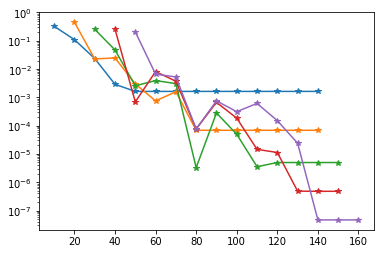

In [22]:
plt.semilogy([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.3264425405026564, 0.10988351901264946, 0.023579171577283998, 0.0028921995466899926, 0.0016222857498242053, 
              0.0016222857498242053, 0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053,
              0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053], '-*')
plt.semilogy([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.45195941022166175, 0.02285357324611735, 0.02471142900936909, 0.002983716837653636, 0.0007493663498527633,
              0.001576359384246577, 6.85688490013715e-05, 6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05,
              6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05], '-*')

plt.semilogy([30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
             [0.25456142925623615, 0.04746437737456692, 0.002562221883428663, 0.003918882311766343, 0.003067142101056196, 
              3.2814072350377507e-06, 0.00028031640532216246, 4.952854907125366e-05, 3.5439482975365948e-06, 4.969237913190993e-06, 
              4.969237915084615e-06, 4.96923791129737e-06, 4.969237909403747e-06], '-*')

plt.semilogy([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
             [0.2572455807208386, 0.0006895962550608181, 0.008137411775710769, 0.0037258115367812903, 7.587643178620754e-05,
              0.000668728273625723, 0.00018374929306915022, 1.4527587541876411e-05, 1.1234823296372392e-05, 4.839784992218223e-07, 
              4.779988583577433e-07, 4.779988564641204e-07], '-*')

plt.semilogy([50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
             [0.2072921179373155, 0.00660700505185869, 0.005274303131263725, 7.653787555651468e-05, 0.0007502321412374746, 
              0.0003119607229560775, 0.0006086017722556336, 0.00015064670949643504, 2.3868413864926134e-05, 4.6510099178571743e-08, 
              4.651009539132593e-08, 4.651010107219464e-08], '-*')

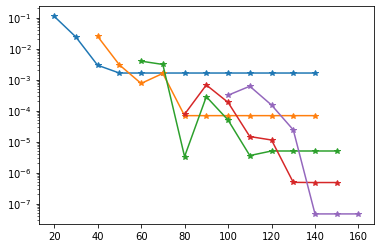

In [3]:
plt.semilogy([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.10988351901264946, 0.023579171577283998, 0.0028921995466899926, 0.0016222857498242053, 
              0.0016222857498242053, 0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053,
              0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053], '-*')
plt.semilogy([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.02471142900936909, 0.002983716837653636, 0.0007493663498527633,
              0.001576359384246577, 6.85688490013715e-05, 6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05,
              6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05], '-*')

plt.semilogy([60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
             [0.003918882311766343, 0.003067142101056196, 
              3.2814072350377507e-06, 0.00028031640532216246, 4.952854907125366e-05, 3.5439482975365948e-06, 4.969237913190993e-06, 
              4.969237915084615e-06, 4.96923791129737e-06, 4.969237909403747e-06], '-*')

plt.semilogy([80, 90, 100, 110, 120, 130, 140, 150], 
             [7.587643178620754e-05,
              0.000668728273625723, 0.00018374929306915022, 1.4527587541876411e-05, 1.1234823296372392e-05, 4.839784992218223e-07, 
              4.779988583577433e-07, 4.779988564641204e-07], '-*')

plt.semilogy([100, 110, 120, 130, 140, 150, 160], 
             [ 0.0003119607229560775, 0.0006086017722556336, 0.00015064670949643504, 2.3868413864926134e-05, 4.6510099178571743e-08, 
              4.651009539132593e-08, 4.651010107219464e-08], '-*')

In [ ]:
num_ = 10, with 50 iterations

dim = 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200

#0.3264425405026564
0.10988351901264946
0.023579171577283998
0.0028921995466899926
0.0016222857498242053
0.0016222857498242053
0.001622285749825152
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053
0.001622285749825152
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053


num_ = 20, with 50 iterations

#0.45195941022166175
#0.02285357324611735
0.02471142900936909
0.002983716837653636
0.0007493663498527633
0.001576359384246577
6.85688490013715e-05
6.856884900326512e-05
6.856884900326512e-05
6.856884900326512e-05
6.856884900326512e-05

num_ = 30, with 50 iterations


#0.25456142925623615
#0.04746437737456692
#0.002562221883428663
0.003918882311766343
0.003067142101056196
3.2814072350377507e-06
0.00028031640532216246
4.952854907125366e-05
3.5439482975365948e-06
4.969237913190993e-06
4.969237915084615e-06
4.96923791129737e-06
4.969237909403747e-06
4.969237915084615e-06

num_ = 40, with 50 iterations

#0.2572455807208386
#0.0006895962550608181
#0.008137411775710769
#0.0037258115367812903
7.587643178620754e-05
0.000668728273625723
0.00018374929306915022
1.4527587541876411e-05
1.1234823296372392e-05
4.839784992218223e-07
4.779988583577433e-07
4.779988564641204e-07

num_ = 50, with 50 iterations

#0.2072921179373155
#0.00660700505185869
#0.005274303131263725
#7.653787555651468e-05
#0.0007502321412374746
0.0003119607229560775
0.0006086017722556336
0.00015064670949643504
2.3868413864926134e-05
4.6510099178571743e-08
4.651009539132593e-08
4.651010107219464e-08

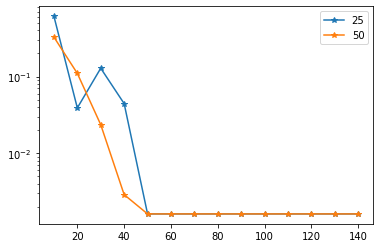

In [29]:
plt.semilogy([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.6098092514897283, 0.03897523969180974, 0.1282289411517143, 0.04438238755674984, 0.0016222857498242053, 
              0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053,
             0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053], '-*')
plt.semilogy([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.3264425405026564, 0.10988351901264946, 0.023579171577283998, 0.0028921995466899926, 0.0016222857498242053, 
              0.0016222857498242053, 0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053,
              0.001622285749825152, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053], '-*')
plt.legend(['25', '50'])

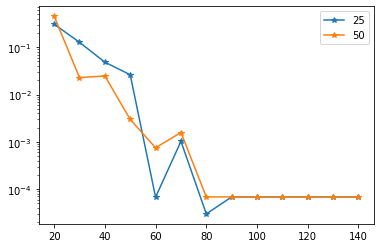

In [28]:
plt.semilogy([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.30762602347736095, 0.1271944410623924, 0.048373646858585674, 0.026195503907737398, 6.770781855579039e-05, 
              0.001025954284087707, 2.9971214089398012e-05, 6.856884900326512e-05, 6.85688490013715e-05,  6.85688490013715e-05,
              6.85688490013715e-05,  6.85688490013715e-05,  6.85688490013715e-05], '-*')

plt.semilogy([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.45195941022166175, 0.02285357324611735, 0.02471142900936909, 0.002983716837653636, 0.0007493663498527633,
              0.001576359384246577, 6.85688490013715e-05, 6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05,
              6.856884900326512e-05, 6.856884900326512e-05, 6.856884900326512e-05], '-*')
plt.legend(['25', '50'])

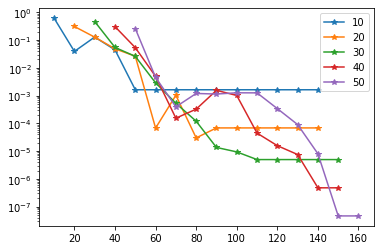

In [30]:
plt.semilogy([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.6098092514897283, 0.03897523969180974, 0.1282289411517143, 0.04438238755674984, 0.0016222857498242053, 
              0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053,
             0.0016222857498242053, 0.0016222857498242053, 0.0016222857498242053], '-*')

plt.semilogy([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], 
             [0.30762602347736095, 0.1271944410623924, 0.048373646858585674, 0.026195503907737398, 6.770781855579039e-05, 
              0.001025954284087707, 2.9971214089398012e-05, 6.856884900326512e-05, 6.85688490013715e-05,  6.85688490013715e-05,
              6.85688490013715e-05,  6.85688490013715e-05,  6.85688490013715e-05], '-*')

plt.semilogy([30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
             [0.46351613548517473, 0.0542030412495333, 0.025882537834670583, 0.0028806632873996426, 0.0005305519943910134, 
              0.0001195463081653112, 1.3583610566669101e-05, 9.395694543051505e-06, 4.969237915084615e-06, 4.969237915084615e-06,
             4.969237915084615e-06, 4.969237915084615e-06, 4.969237915084615e-06], '-*')

plt.semilogy([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
             [0.30456991743077, 0.053228178321106843, 0.004925889271754823, 0.00015369482198011766, 0.00032491999200200334, 
              0.0015467279850818736, 0.0010107461057735935, 4.459236437626378e-05, 1.5723429645033894e-05, 7.552573341240473e-06, 
              4.779988621449891e-07, 4.779988621449891e-07], '-*')

plt.semilogy([50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
             [0.25983070000336095, 0.004530551983840198, 0.00039447373646318975, 0.0011929784108137345, 0.0011379344234534643, 
              0.0012606829139984491, 0.0012536975459668635, 0.00033996711615858003, 9.054256636287372e-05, 8.043471733268505e-06, 
              4.651010107219464e-08, 4.6510099178571743e-08], '-*')
plt.legend(['10', '20', '30', '40', '50'])

In [ ]:
num_ = 10, with 25 iterations

dim = 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200

0.6098092514897283
0.03897523969180974
0.1282289411517143
0.04438238755674984
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053


num_ = 20, with 25 iterations

0.30762602347736095
0.1271944410623924
0.048373646858585674
0.026195503907737398
6.770781855579039e-05
0.001025954284087707
2.9971214089398012e-05
6.856884900326512e-05
6.85688490013715e-05

num_ = 30, with 25 iterations

0.46351613548517473
0.0542030412495333
0.025882537834670583
0.0028806632873996426
0.0005305519943910134
0.0001195463081653112
1.3583610566669101e-05
9.395694543051505e-06
4.969237915084615e-06
4.969237915084615e-06

num_ = 40, with 25 iterations

0.30456991743077
0.053228178321106843
0.004925889271754823
0.00015369482198011766
0.00032491999200200334
0.0015467279850818736
0.0010107461057735935
4.459236437626378e-05
1.5723429645033894e-05
7.552573341240473e-06
4.779988621449891e-07

num_ = 50, with 25 iterations
0.25983070000336095
0.004530551983840198
0.00039447373646318975
0.0011929784108137345
0.0011379344234534643
0.0012606829139984491
0.0012536975459668635
0.00033996711615858003
9.054256636287372e-05
8.043471733268505e-06
4.651010107219464e-08
4.6510099178571743e-08
4.651010485944045e-08
4.651010296581755e-08

In [33]:
dim = 50
for num_ in range(25):

    result_1 = []
    for index_ in range(num_):
        x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(50):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(50):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])

    err = (logdet_approx - logdet)/logdet
    print(abs(err))

1.0
0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.001303273569788569
0.0014908528732889335
0.002075430059463501
0.0020088233186265157
0.001983988981644923
0.001958376100802941


KeyboardInterrupt: 

In [10]:
num_ = 20

for dim in [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]:

    result_1 = []
    for index_ in range(num_):
        x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])

    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.10273501482074346
0.0009450269451528963
0.0006634119831790749
0.0010702480094957661
6.85688490013715e-05
6.856884900326512e-05


KeyboardInterrupt: 

In [ ]:
num = 10 , iter 100

dim = 20, 30, 40, 50, 60
0.19081291128986588
0.01623125650614094
0.09505357664952965
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053
0.0016222857498242053


num = 20, iter 100
dim = 40, 50, 60, 70, 80, 90
0.10273501482074346
0.0009450269451528963
0.0006634119831790749
0.0010702480094957661
6.85688490013715e-05
6.856884900326512e-05

num = 30, iter 100


In [5]:
for num in range(38, 50+1):
    result_1 = []
    for index_ in range(num):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 100, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)

    result_2 = []
    for index_ in range(1, num+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 100, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)

    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.0005262051370207971
0.0005262824963129617
0.0005263459515821441
0.0005263923436674296
0.00012740549841018712
0.00010455820298848019
0.00010723962818614586
0.00010208085614115473
9.646568353209955e-05
9.662561782460324e-05
0.0001005727359308061
8.586517819441133e-05
8.696922524399758e-05


In [5]:
num = 40
result_1_80 = []
for index_ in range(num):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 80, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[index_]
        v_index = list(evalue).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_1_80.append(rho_)

result_2_80 = []
for index_ in range(1, num+1):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 80, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[-index_]
        v_index = list(evalue).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_2_80.append(rho_)

In [6]:
result_80 = result_1_80 + result_2_80

In [7]:
print(result_80)

[0.7021660931758322, 0.9043124458898857, 0.9043860910573961, 0.9421934664049058, 0.9737525286945633, 0.9737893966140317, 0.97909310969107, 0.979103936899847, 0.9875697482945321, 0.9932273305554089, 0.99323467571907, 0.9939224875522542, 0.9939376035481411, 0.9953101015920114, 0.9953150180428074, 0.9972053230845198, 0.9982935273482993, 0.9982974316592778, 0.9983927751699329, 0.9983944529521848, 0.9985888466845899, 0.998590873616076, 0.998939138105022, 0.9989452777604301, 0.999359801260965, 0.9995765993209056, 0.9995936483023001, 0.9996209016513438, 0.999651922980221, 0.9996700468032702, 0.9998119091894148, 0.9997680457143734, 0.9997718373709988, 0.9999519513058359, 0.9998490875085742, 0.9998937046775819, 0.999904511065067, 0.9999298341762752, 0.9999551146834625, 0.9999806554178965, 1.2978339068241678, 1.0956875541101143, 1.095613908942604, 1.0578065335950941, 1.0262474713054368, 1.0262106033859684, 1.02090689030893, 1.020896063100153, 1.0124302517054677, 1.006772669444591, 1.006765324280

In [8]:
err_eigens_80 = []
for i in range(40):
    err_eigens_80.append(abs(sorted(evals)[i] - result_1_80[i])/sorted(evals)[i])
for j in range(40):
    err_eigens_80.append(abs((sorted(evals)[-40:])[j] - sorted(result_2_80)[j])/(sorted(evals)[-40:])[j])

In [10]:
print(err_eigens_80)

[(1.8973682188561144e-15+0j), (4.910793961406313e-16+0j), (1.7186379244929954e-15+0j), (2.3566774005797236e-16+0j), 0j, (6.84063532722077e-16+0j), (1.1339299742140566e-15+0j), (1.1339174348950877e-16+0j), (1.5738759081669081e-15+0j), (1.4531315113989296e-15+0j), (2.1237918876127103e-15+0j), (2.010621018593487e-15+0j), (4.467978757064436e-16+0j), (4.461817569617111e-16+0j), (1.561628435519469e-15+0j), (1.22466787813583e-15+0j), (1.6681812426063197e-15+0j), (2.113021309973425e-15+0j), (1.5568143852109335e-15+0j), (1.5568117690149628e-15+0j), (1.0006127401483417e-15+0j), (1.22296864447131e-15+0j), (1.0002618618568857e-15+0j), (1.3336742854794273e-15+0j), (1.9996816379883975e-15+0j), (1.7771092686714276e-15+0j), (1.655569073101027e-05+0j), (2.8321490056169695e-05+0j), (5.8282173541936296e-05+0j), (4.9163789840206744e-05+0j), (0.0001904487014958443+0j), (9.803126839878525e-05+0j), (9.563276331343738e-05+0j), (0.00018328443876631362+0j), (7.726776719165754e-05+0j), (4.462390331081473e-05+0j)